# Interpreting the output of `find_adversarial_example`

Using the same example from the quickstart, we explore what information is available from the result of `find_adversarial_example`.

In [1]:
using MIPVerify
using HiGHS
using JuMP
using Images

mnist = MIPVerify.read_datasets("MNIST")
n1 = MIPVerify.get_example_network_params("MNIST.n1")
sample_image = MIPVerify.get_image(mnist.test.images, 1);

function view_diff(diff::Array{<:Real, 2})
    n = 1001
    colormap("RdBu", n)[ceil.(Int, (diff .+ 1) ./ 2 .* n)]
end;

Let's take a look at the output dictionary that results from a solve.

In [2]:
d1 = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10, 
    HiGHS.Optimizer,
    Dict(),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.05),
    norm_order = Inf,
    tightening_algorithm = lp,
)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
1779 rows, 1627 cols, 56716 nonzeros
1779 rows, 1627 cols, 56716 nonzeros

Solving MIP model with:
   1779 rows
   1627 cols (29 binary, 0 integer, 0 implied int., 1598 continuous)
   56716 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   0               inf                  inf        0 

Dict{Any, Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 21.6141
  :TotalTime          => 38.8481
  :Perturbation       => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :PerturbedInput     => [_[785] _[786] … _[811] _[812];;; _[813] _[814] … _[83…
  :TighteningApproach => "lp"
  :PerturbationFamily => linf-norm-bounded-0.05
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => AffExpr[-0.012063867412507534 _[1601] + 0.660652577877…
  :PredictedIndex     => 8

### `:Model`

The model stores a lot of information. (Remember not to try to print large models!) 

In [3]:
m = d1[:Model];

Here are some `JuMP` methods you might find useful.

In [4]:
num_variables(m)

2411

In [5]:
num_constraints(m, VariableRef, MOI.GreaterThan{Float64})

2381

In [6]:
solve_time(m)

21.61407446861267

In this case, the lower bound on the objective and the best value we found is the same (but it can be different if we set time or other user limits)

In [7]:
objective_bound(m)

0.046084681588922406

In [8]:
objective_value(m)

0.046084681588922406

### `:PerturbationFamily`

Information on the family of perturbations we are searching over is stored in `:PerturbationFamily`.

In [9]:
d1[:PerturbationFamily]

linf-norm-bounded-0.05

### `:TargetIndexes`

The perturbed image is guaranteed to be classified in one of the target indexes. (Strictly speaking, we guarantee that the highest activation in the output layer among the target indexes is at least highest activation in the output layer among non-target indexes within a small numeric tolerance).

In [10]:
d1[:TargetIndexes]

1-element Vector{Int64}:
 10

Multiple target labels and an inverted target selection are appropriately handled.

In [11]:
d2 = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    8,
    HiGHS.Optimizer,
    Dict("time_limit" => 5.0),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.05),
    norm_order = Inf,
    tightening_algorithm = lp,
    invert_target_selection = true,
)
d2[:TargetIndexes]

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1, 2, 3, 4, 5, 6, 7, 9, 10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
1790 rows, 1637 cols, 64883 nonzeros
1790 rows, 1637 cols, 64883 nonzeros

Solving MIP model with:
   1790 rows
   1637 cols (38 binary, 0 integer, 0 implied int., 1599 continuous)
   64883 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   0               inf       

9-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  9
 10

### `:SolveStatus`

This is the result of the solve. [More information on solve statuses](https://jump.dev/MathOptInterface.jl/stable/apireference/#MathOptInterface.TerminationStatusCode)

We typically find an optimal solution:

In [12]:
d1[:SolveStatus]

OPTIMAL::TerminationStatusCode = 1

But we can encounter other solve statuses if (for instance) we set a time limit.

In [13]:
d2[:SolveStatus]

TIME_LIMIT::TerminationStatusCode = 12

### `:Perturbation`

This is the (pixel-wise) difference between the original image and the perturbed image.

In [14]:
perturbation = JuMP.value.(d1[:Perturbation])

1×28×28×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0460847  0.0  0.0  0.0460847  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0460847

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0460847  0.0460847  0.0  …  0.0  0.0  0.0  0.0  0.0460847

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0460847  …  0.0  0.0  0.0460847  0.0  0.0

;;; … 

[:, :, 26, 1] =
 0.0  0.0  0.0460847  0.0  0.0  0.0  0.0  …  0.0460847  0.0460847  0.0  0.0

[:, :, 27, 1] =
 0.0460847  0.0460847  0.0  0.0  0.0  0.0  …  0.0460847  0.0  0.0460847

[:, :, 28, 1] =
 0.0460847  0.0  0.0460847  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0460847  0.0

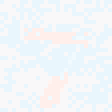

In [15]:
view_diff(perturbation[1, :, :, 1])

### `:PerturbedInput`

This is the perturbed image.

In [16]:
perturbed_input = JuMP.value.(d1[:PerturbedInput])

1×28×28×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0460847  0.0  0.0  0.0460847  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0460847

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0460847  0.0460847  0.0  …  0.0  0.0  0.0  0.0  0.0460847

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0460847  …  0.0  0.0  0.0460847  0.0  0.0

;;; … 

[:, :, 26, 1] =
 0.0  0.0  0.0460847  0.0  0.0  0.0  0.0  …  0.0460847  0.0460847  0.0  0.0

[:, :, 27, 1] =
 0.0460847  0.0460847  0.0  0.0  0.0  0.0  …  0.0460847  0.0  0.0460847

[:, :, 28, 1] =
 0.0460847  0.0  0.0460847  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0460847  0.0

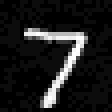

In [17]:
colorview(Gray, perturbed_input[1, :, :, 1])

We can verify that the perturbed input is in fact the sample image added to the perturbation.

In [18]:
all(perturbed_input == sample_image + perturbation)

false

### `:Output`

This is the calculated value of the activations of the final layer of the neural net with the perturbed input. Note that `output[10]` is (tied for) the largest element of the array.

In [19]:
output = JuMP.value.(d1[:Output])

10-element Vector{Float64}:
  0.6749450628745499
  0.6179790360668559
  0.39303215980893874
  0.29656185967035825
  0.24101053495482927
  0.1606002120357409
  0.5428526100447263
  4.288351484573891
 -0.22643018233076517
  4.288351484573884

We can verify that these activations are indeed accurate:

In [20]:
perturbed_input |> n1

10-element Vector{Float64}:
  0.6749450628745521
  0.6179790360668558
  0.3930321598089389
  0.29656185967035864
  0.24101053495482938
  0.16060021203574099
  0.5428526100447264
  4.288351484573887
 -0.22643018233076218
  4.2883514845738775